<a href="https://colab.research.google.com/github/lecture-series-2021/lecture3and4/blob/main/lecture3and4_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single- and Multi-View Geometry



## Setup and Utility Functions

In [20]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import io
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

In [21]:
# downloads from a publicly accessible Google Drive folder with ID folder_id
def download_files_in_folder(folder_id):
  response = drive_service.files().list(q=f"'{folder_id}' in parents and trashed = false",
                                        spaces='drive',
                                        fields='nextPageToken, files(id, name)',
                                        pageToken=None).execute()
  data = {}
  for file in response.get('files', []):
    filename = file.get("name")
    fileid = file.get("id")
    print(f'Found file: {filename} ({fileid})')
    request = drive_service.files().get_media(fileId=fileid)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
      _, done = downloader.next_chunk()
    downloaded.seek(0)
    data[filename] = downloaded
  return data

In [22]:
def transform_points(bp, aHb):
  """
  Inputs:
  - bp: Nx2 array of 2D points in image B corresponding to ap in image A
  - aHb: 3x3 homography matrix that transforms points from image B to image A
  Outputs:
  Single number: re-projection error from comparing ap to aHb*bp
  """
  bp = np.vstack((bp.T, np.ones(len(bp))))
  abp = aHb @ bp
  abp = abp[:2] / abp[2]
  abp = abp.T
  return abp  

In [23]:
def reprojection_error(ap, bp, aHb):
  """
  Inputs:
  - ap: Nx2 array of 2D points in image A corresponding to bp in image B
  - bp: Nx2 array of 2D points in image B corresponding to ap in image A
  - aHb: 3x3 homography matrix that transforms points from image B to image A
  Outputs:
  Single number: re-projection error from comparing ap to aHb*bp
  """
  assert(len(ap) == len(bp))  
  abp = transform_points(bp, aHb)
  return np.mean(np.linalg.norm(ap-abp, axis=-1))

In [24]:
chessboard_shape = (10, 7)
chessboard_sq_size = 5.0
def get_canonical_corners(shape=chessboard_shape,
                          square_size=chessboard_sq_size):
  """
  Inputs:
  - shape: tuple (W, H) number of inner corners in the chessboard, used for
  OpenCV findChessboardCorners()
  - square_size: side length of each chessboard square. The actual value does
  matter for our problem
  Outputs:
  W*H x 2 array of chessboard corner locations in the chessboard coordinate 
  system (X axis = width, Y axis = length, Z axis out of the plane)
  """
  x = np.linspace(0.0, 1.0, shape[0]) * shape[0]*square_size
  y = np.linspace(0.0, 1.0, shape[1]) * shape[1]*square_size
  xx, yy = np.meshgrid(x, y)
  return np.array([(x, y) for x,y in zip(xx.flatten(), yy.flatten())])

In [25]:
def normalization_matrix(p):
  """
  Normalizes the data to improve the numerical stability of DLT
  (Algorithm 4.2 in Hartley and Zisserman)
  Inputs:
  - p: 3xN array of homogeneous 2D points, each column is (x, y, 1)^T
  Outputs:
  - T: 3x3 matrix that transforms p such that:
      - the mean of all points is (0, 0, 0),
      - average distance of all points from origin is sqrt(2)
  """
  m = np.mean(p, axis=1, keepdims=True)
  s = np.sqrt(2) / np.mean(np.linalg.norm(p-m, axis=0))
  T = np.diag((s, s, 1))
  T[:2, 2] = -m[:2, 0]
  # print('T\n', T)
  return T

## Get Data

In [26]:
data = download_files_in_folder('11DQJM-Y8nEtY6hXklUtNl2i5skcGmmwk')

# images
ims = [np.array(Image.open(data['chessboard0.png'])),
       np.array(Image.open(data['chessboard1.png']))]

# corners
corners = [np.loadtxt(data['chessboard0.txt']),
           np.loadtxt(data['chessboard1.txt'])]

# images for showing
ims_show = [np.array(Image.open(data['chessboard0_corners.png'])),
            np.array(Image.open(data['chessboard1_corners.png']))]

Found file: chessboard1.txt (1PDQ7p0iaRVYEvEzYrYB9RcTbskv1-Rk5)
Found file: chessboard1_corners.png (1W0JvAdLg_8kKZv7t9RzYIQHhGQ4ZCT3C)
Found file: chessboard0.txt (158bkvcDgA1SSLPGKTvFMqUQXQht8tY3e)
Found file: chessboard0_corners.png (1UNdJpmqRqHqHr9qWvid4R2MFNtwYaN9c)
Found file: chessboard1.png (1cPvLgpWv-jB1nakJTcghfKRroekXzgyd)
Found file: chessboard0.png (1PjgvNZayEZE0NuekryR-4pdRHdCL8iNk)


We have provided pre-detected chessboard corners in the "corners" array.
Chessboard corners were detected with OpenCV's [`findChessboardCorners()`](https://docs.opencv.org/3.4.2/d9/d0c/group__calib3d.html#ga93efa9b0aa890de240ca32b11253dd4a) function.

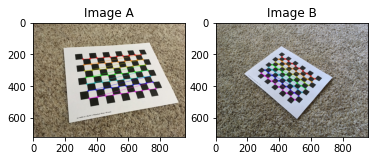

In [27]:
_, axs = plt.subplots(1, 2)
axs[0].imshow(ims_show[0])
axs[0].set_title('Image A')
axs[1].imshow(ims_show[1])
axs[1].set_title('Image B')
plt.show()

## Homework-1: Fit Homography using DLT

In [28]:
def fitHomography(ap, bp):
  """
  Inputs:
  - ap: Nx3 array of homogeneous 2D points in image A corresponding to bp in image B
  - bp: Nx3 array of homogeneous 2D points in image B corresponding to ap in image A
  Outputs:
  - aHb: 3x3 homography matrix that transforms points from image B to image A
  """
  ### write your code here
  aHb = np.eye(3)  # dummy matrix, erase after writing your code above
  return aHb

## Solution of Homework-1
Click the black arrow to the left of "Solution" to peek at the solution

In [29]:
def fitHomography_solution(ap, bp):
  """
  Inputs:
  - ap: Nx3 array of homogeneous 2D points in image A corresponding to bp in image B
  - bp: Nx3 array of homogeneous 2D points in image B corresponding to ap in image A
  Outputs:
  - aHb: 3x3 homography matrix that transforms points from image B to image A
  """
  # create A matrix
  A = []
  for idx, (a, b) in enumerate(zip(ap, bp)):
    v = np.hstack((np.zeros(3), -a[2]*b, a[1]*b))
    A.append(v)
    v = np.hstack((a[2]*b, np.zeros(3), -a[0]*b))
    A.append(v)
  A = np.vstack(A)

  # Do SVD and create H in normalized space
  U, S, Vt = np.linalg.svd(A)
  # print(S)
  aHb = np.reshape(Vt[-1], (3, 3))
  # print('H\n', aHb)

  return aHb

# End of Solution

In [30]:
def fitHomographyNormalized(ap, bp):
  """
  Wrapper around fitHomography(), which first normalizes the data using
  normalization_matrix(), then calls fitHomography(), then un-normalizes
  its output
  Inputs:
  - ap: Nx2 array of 2D points in image A corresponding to bp in image B
  - bp: Nx2 array of 2D points in image B corresponding to ap in image A
  Outputs:
  - aHb: 3x3 homography matrix that transforms points from image B to image A
  """
  assert(len(ap) == len(bp))
  ap = np.hstack((ap, np.ones((len(ap), 1))))  # Nx3
  bp = np.hstack((bp, np.ones((len(bp), 1))))  # Nx3

  # normalize
  aT = normalization_matrix(ap.T)
  ap =(aT @ ap.T).T
  bT = normalization_matrix(bp.T)
  bp = (bT @ bp.T).T

  aHb = fitHomography(ap, bp)

  # H in un-normalized space
  aHb = np.linalg.inv(aT) @ aHb @ bT

  return aHb

## Canonical chessboard corners

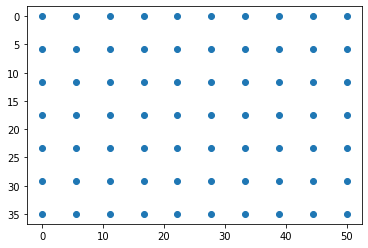

In [31]:
canonical_corners = get_canonical_corners()
plt.scatter(canonical_corners[:, 0], canonical_corners[:, 1])
ax=plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()

## Homework-2: Copy-Paste Chessboard by Inverse Warping

In [32]:
def transfer_chessboard(image_a, corners_a, image_b, corners_b,
                        canonical_corners, chessboard_shape=chessboard_shape,
                        chessboard_sq_size=chessboard_sq_size):
  """
  Inputs:
  - image_a: HxWx3 Image A
  - corners_a: Nx2 array of corners in image A. Each row in (x, y) format
  - image_b: HxWx3 Image B
  - corners_b: Nx2 array of corners in image B. Each row in (x, y) format
  - canonical_corners: Nx2 array of canonical corners. Each row in (x, y) format
  - chessboard_shape: (W, H) number of corners in the chessboard
  - chessboard_sq_size: size of 1 square in the chessboard used to calculate
                        canonical_corners
  Returns:
  - image: HxWx3 image B containing chessboard copy-pasted from image A
  """
  ### write your code here
  show_image_b = np.copy(image_b)  # copy of image B, erase after writing your code above
  return show_image_b

## Solution of Homework-2
Click the black arrow to the left of "Solution" to peek at the solution

In [33]:
def transfer_chessboard_solution(image_a, corners_a, image_b, corners_b,
                        canonical_corners, chessboard_shape=chessboard_shape,
                        chessboard_sq_size=chessboard_sq_size):
  """
  Inputs:
  - image_a: HxWx3 Image A
  - corners_a: Nx2 array of corners in image A. Each row in (x, y) format
  - image_b: HxWx3 Image B
  - corners_b: Nx2 array of corners in image B. Each row in (x, y) format
  - canonical_corners: Nx2 array of canonical corners. Each row in (x, y) format
  - chessboard_shape: (W, H) number of corners in the chessboard
  - chessboard_sq_size: size of 1 square in the chessboard used to calculate
                        canonical_corners
  Returns:
  - image: HxWx3 image B containing chessboard copy-pasted from image A
  """
  ##### Compute homographies
  ap = np.copy(corners_a)
  bp = np.copy(corners_b)
  cp = np.copy(canonical_corners)

  # from image B to canonical
  print('## B -> Canonical')
  cHb = fitHomographyNormalized(cp, bp)
  r_err = reprojection_error(cp, bp, cHb)
  print(f'Forward reprojection error = {r_err}')
  r_err = reprojection_error(bp, cp, np.linalg.inv(cHb))
  print(f'Reverse reprojection error = {r_err}')

  # from canonical to image A
  print('## Canonical -> A')
  aHc = fitHomographyNormalized(ap, cp)
  r_err = reprojection_error(ap, cp, aHc)
  print(f'Forward reprojection error = {r_err}')
  r_err = reprojection_error(cp, ap, np.linalg.inv(aHc))
  print(f'Reverse reprojection error = {r_err}')

  ### Do warping
  # list of all pixels in B
  H, W, _ = image_b.shape
  xxb, yyb = np.meshgrid(range(W), range(H))
  pb = np.vstack((xxb.flatten(), yyb.flatten())).T

  # transform pb to canonical chessboard coordinate system
  pc = transform_points(pb, cHb)
  Wc = chessboard_shape[0] * chessboard_sq_size
  Hc = chessboard_shape[1] * chessboard_sq_size
  # see which transformed pb fall inside the chessboard boundary
  keep_idx = np.logical_and(pc[:,0]>0, pc[:,1]>0)
  keep_idx = np.logical_and(keep_idx, pc[:,0]<=Wc)
  keep_idx = np.logical_and(keep_idx, pc[:,1]<=Hc)
  # ignore points outside the chessboard boundary
  pb = pb[keep_idx]
  pc = pc[keep_idx]

  # transform the chessboard points to image A
  pa = transform_points(pc, aHc)
  pa = np.round(pa).astype(np.int)
  # see which transformed pc fall inside the image A boundary
  keep_idx = np.logical_and(pa[:,0]>=0, pa[:,1]>=0)
  keep_idx = np.logical_and(keep_idx, pa[:,0]<W)
  keep_idx = np.logical_and(keep_idx, pa[:,1]<H)
  # ignore points outside the image A boundary
  pb = pb[keep_idx]
  pc = pc[keep_idx]
  pa = pa[keep_idx]

  ### Copy the color from image A to image B
  show_image_b = np.copy(image_b)
  show_image_b[pb[:, 1], pb[:, 0], :] = image_a[pa[:, 1], pa[:, 0], :]
  return show_image_b

## Show Results

## B -> Canonical
Forward reprojection error = 0.04222698937655148
Reverse reprojection error = 0.1993336958838861
## Canonical -> A
Forward reprojection error = 0.5826622900645511
Reverse reprojection error = 0.08547311745898925


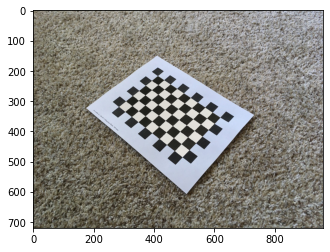

In [34]:
# transfer chessboard from image A to B
im_show = transfer_chessboard(ims[0], corners[0], ims[1], corners[1],
                              canonical_corners)
plt.imshow(im_show)
plt.show()

## B -> Canonical
Forward reprojection error = 0.09088835239237117
Reverse reprojection error = 0.6422486280115199
## Canonical -> A
Forward reprojection error = 0.20189076188813604
Reverse reprojection error = 0.043444157980542124


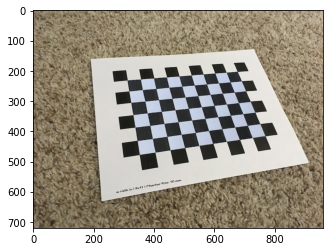

In [35]:
# transfer chessboard from image B to A
im_show = transfer_chessboard(ims[1], corners[1], ims[0], corners[0],
                              canonical_corners)
plt.imshow(im_show)
plt.show()